# SSD Evaluation for Leaf Detect



In [1]:
from keras import backend as K
from keras.models import load_model
from keras.optimizers import Adam
from scipy.misc import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from models.keras_ssd300 import ssd_300
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization
from data_generator.object_detection_2d_data_generator import DataGenerator
from eval_utils.average_precision_evaluator import Evaluator

%matplotlib inline

Using TensorFlow backend.


In [3]:
# Set a few configuration parameters.
img_height = 256
img_width = 256
model_mode = 'inference'
img_height = 256 # Height of the input images
img_width = 256 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 5 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = True # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size


print("done")

done


## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [4]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='inference',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

# 2: Optional: Load some weights

#model.load_weights('./ssd7_weights.h5', by_name=True)

#weights_path = 'VGG_ILSVRC_16_layers_fc_reduced.h5'

weights_path = 'ssd7_potato_leaf_epoch-05.h5'


model.load_weights(weights_path, by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

model.summary()

W0110 17:25:36.035645 140388460812096 module_wrapper.py:139] From /home/ubuntu/anaconda2/envs/tf_training/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0110 17:25:36.039686 140388460812096 module_wrapper.py:139] From /home/ubuntu/anaconda2/envs/tf_training/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0110 17:25:36.047081 140388460812096 module_wrapper.py:139] From /home/ubuntu/anaconda2/envs/tf_training/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0110 17:25:36.060017 140388460812096 module_wrapper.py:139] From /home/ubuntu/anaconda2/envs/tf_training/lib/python3.7/site-packages/keras/backend/tensorflow_backend.p

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 256, 256, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 256, 256, 3)  0           input_mean_normalization[0][0]   
__________________________________________________________________________________________________
conv1 (Con

Or

### 1.2. Load a trained model

We set `model_mode` to 'inference' above, so the evaluator expects that you load a model that was built in 'inference' mode. If you're loading a model that was built in 'training' mode, change the `model_mode` parameter accordingly.

In [ ]:
# TODO: Set the path to the `.h5` file of the model to be loaded.
#model_path = 'ssd7_leaf10_epoch-117.h5'

model_path = 'ssd7_potato_leaf_epoch-03.h5'

# We need to create an SSDLoss object in order to pass that to the model loader.
ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

K.clear_session() # Clear previous models from memory.

model = load_model(model_path, custom_objects={'AnchorBoxes': AnchorBoxes,
                                               'compute_loss': ssd_loss.compute_loss})

model.summary()

## 2. Create a data generator for the evaluation dataset

Instantiate a `DataGenerator` that will serve the evaluation dataset during the prediction phase.

In [11]:
dataset = DataGenerator()


VOC_2019_images_dir      = '/hdd/data/LeafDetectData/LEAF2019/JPEGImages/'

VOC_2019_annotations_dir      = '/hdd/data/LeafDetectData/LEAF2019/Annotations/'

VOC_2019_trainval_image_set_filename = '/hdd/data/LeafDetectData/LEAF2019/ImageSets/Main/trainval_potato.txt'

VOC_2019_test_image_set_filename     = '/hdd/data/LeafDetectData/LEAF2019/ImageSets/Main/test_potato.txt'

classes = [ 'background',
            'Potato_healthy',
            'Infected_Potato_Early_blight',
            'Potato_Early_blight',
            'Infected_Potato_Late_blight',
            'Potato_Late_blight',
]


dataset.parse_xml(images_dirs=[VOC_2019_images_dir],
                  image_set_filenames=[VOC_2019_test_image_set_filename],
                  annotations_dirs=[VOC_2019_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=False,
                  ret=False)

Processing image set 'test_potato.txt': 100%|██████████| 160/160 [00:01<00:00, 97.90it/s]


## 3. Run the evaluation

Now that we have instantiated a model and a data generator to serve the dataset, we can set up the evaluator and run the evaluation.

The evaluator is quite flexible: It can compute the average precisions according to the Pascal VOC pre-2010 algorithm, which samples 11 equidistant points of the precision-recall curves, or according to the Pascal VOC post-2010 algorithm, which integrates numerically over the entire precision-recall curves instead of sampling a few individual points. You could also change the number of sampled recall points or the required IoU overlap for a prediction to be considered a true positive, among other things. Check out the `Evaluator`'s documentation for details on all the arguments.

In its default settings, the evaluator's algorithm is identical to the official Pascal VOC pre-2010 Matlab detection evaluation algorithm, so you don't really need to tweak anything unless you want to.

The evaluator roughly performs the following steps: It runs predictions over the entire given dataset, then it matches these predictions to the ground truth boxes, then it computes the precision-recall curves for each class, then it samples 11 equidistant points from these precision-recall curves to compute the average precision for each class, and finally it computes the mean average precision over all classes.

In [12]:
evaluator = Evaluator(model=model,
                      n_classes=n_classes,
                      data_generator=dataset,
                      model_mode=model_mode)

results = evaluator(img_height=img_height,
                    img_width=img_width,
                    batch_size=16,
                    data_generator_mode='resize',
                    round_confidences=False,
                    matching_iou_threshold=0.5,
                    border_pixels='include',
                    sorting_algorithm='quicksort',
                    average_precision_mode='sample',
                    num_recall_points=11,
                    ignore_neutral_boxes=True,
                    return_precisions=True,
                    return_recalls=True,
                    return_average_precisions=True,
                    verbose=True)

mean_average_precision, average_precisions, precisions, recalls = results

Number of images in the evaluation dataset: 160

Matching predictions to ground truth, class 5/5.: 100%|██████████| 135/135 [00:00<00:00, 5187.69it/s]
Computing precisions and recalls, class 1/5
Computing precisions and recalls, class 2/5
Computing precisions and recalls, class 3/5
Computing precisions and recalls, class 4/5
Computing precisions and recalls, class 5/5
Computing average precision, class 1/5
Computing average precision, class 2/5
Computing average precision, class 3/5
Computing average precision, class 4/5
Computing average precision, class 5/5


## 4. Visualize the results

Let's take a look:

In [13]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], '  AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

Potato_healthy  AP  0.991
Infected_Potato_Early_blight  AP  0.024
Potato_Early_blight  AP  0.0
Infected_Potato_Late_blight  AP  0.027
Potato_Late_blight  AP  0.01

              mAP   0.21


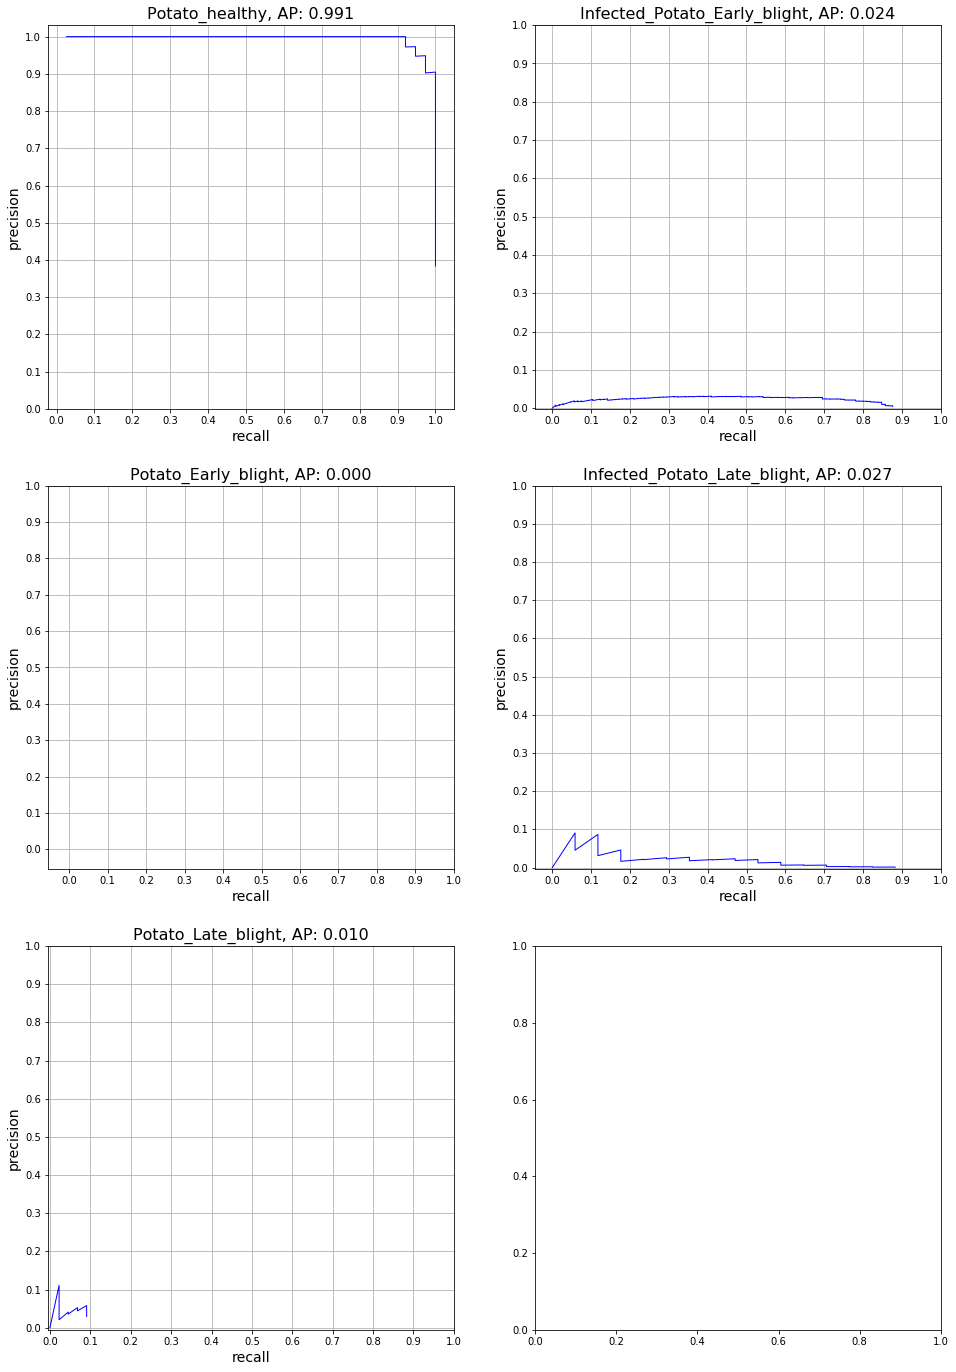

In [14]:
m = max((n_classes + 1) // 2, 2)
n = 2

fig, cells = plt.subplots(m, n, figsize=(n*8,m*8))
for i in range(m):
    for j in range(n):
        if n*i+j+1 > n_classes: break
        cells[i, j].plot(recalls[n*i+j+1], precisions[n*i+j+1], color='blue', linewidth=1.0)
        cells[i, j].set_xlabel('recall', fontsize=14)
        cells[i, j].set_ylabel('precision', fontsize=14)
        cells[i, j].grid(True)
        cells[i, j].set_xticks(np.linspace(0,1,11))
        cells[i, j].set_yticks(np.linspace(0,1,11))
        cells[i, j].set_title("{}, AP: {:.3f}".format(classes[n*i+j+1], average_precisions[n*i+j+1]), fontsize=16)

## 5. Advanced use

`Evaluator` objects maintain copies of all relevant intermediate results like predictions, precisions and recalls, etc., so in case you want to experiment with different parameters, e.g. different IoU overlaps, there is no need to compute the predictions all over again every time you make a change to a parameter. Instead, you can only update the computation from the point that is affected onwards.

The evaluator's `__call__()` method is just a convenience wrapper that executes its other methods in the correct order. You could just call any of these other methods individually as shown below (but you have to make sure to call them in the correct order).

Note that the example below uses the same evaluator object as above. Say you wanted to compute the Pascal VOC post-2010 'integrate' version of the average precisions instead of the pre-2010 version computed above. The evaluator object still has an internal copy of all the predictions, and since computing the predictions makes up the vast majority of the overall computation time and since the predictions aren't affected by changing the average precision computation mode, we skip computing the predictions again and instead only compute the steps that come after the prediction phase of the evaluation. We could even skip the matching part, since it isn't affected by changing the average precision mode either. In fact, we would only have to call `compute_average_precisions()` `compute_mean_average_precision()` again, but for the sake of illustration we'll re-do the other computations, too.

In [15]:
evaluator.get_num_gt_per_class(ignore_neutral_boxes=True,
                               verbose=False,
                               ret=False)

evaluator.match_predictions(ignore_neutral_boxes=True,
                            matching_iou_threshold=0.5,
                            border_pixels='include',
                            sorting_algorithm='quicksort',
                            verbose=True,
                            ret=False)

precisions, recalls = evaluator.compute_precision_recall(verbose=True, ret=True)

average_precisions = evaluator.compute_average_precisions(mode='integrate',
                                                          num_recall_points=11,
                                                          verbose=True,
                                                          ret=True)

mean_average_precision = evaluator.compute_mean_average_precision(ret=True)

Matching predictions to ground truth, class 5/5.: 100%|██████████| 135/135 [00:00<00:00, 7686.05it/s]
Computing precisions and recalls, class 1/5
Computing precisions and recalls, class 2/5
Computing precisions and recalls, class 3/5
Computing precisions and recalls, class 4/5
Computing precisions and recalls, class 5/5
Computing average precision, class 1/5
Computing average precision, class 2/5
Computing average precision, class 3/5
Computing average precision, class 4/5
Computing average precision, class 5/5


In [10]:
for i in range(1, len(average_precisions)):
    print("{:<14}{:<6}{}".format(classes[i], '   AP', round(average_precisions[i], 3)))
print()
print("{:<14}{:<6}{}".format('','mAP', round(mean_average_precision, 3)))

Potato_healthy   AP 0.972
Infected_Potato_Early_blight   AP 0.025
Potato_Early_blight   AP 0.0
Infected_Potato_Late_blight   AP 0.029
Potato_Late_blight   AP 0.007

              mAP   0.207
